# 타이타닉 생존자 예측하기


```
실습목표
1. 타이타닉 데이터셋을 불러와서 모델에 입력하기 전 다양한 형태로 살펴봅니다.
2. 분류모델에 넣을 피처를 만들고 선택합니다.
3. 모델을 학습 시킨 후 성능을 평가합니다.

```



```
실습단계
1. 라이브러리 임포트
2. 데이터셋 로드 및 전처리
3. 모델 로드
4. 모델 학습
5. 모델 평가 및 예측
6. 결과 시각화

```


### 1.라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


### 2.데이터셋 로드 및 전처리


In [2]:
# 데이터셋 로드
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

#### 2-1.EDA(탐색적 데이터 분석)

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


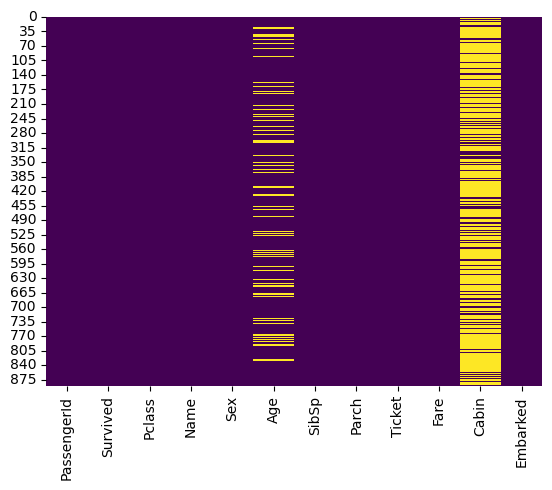

In [6]:
# 결측값 시각화
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

#### 2-2.피처 엔지니어링 및 전처리

- 빈 나이(age)값들은 중간값( 평균 아님) 으로 채우기

In [7]:
df['Age'].fillna(df['Age'].median(), inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- 비어있는 선착장 정보는, 가장 적은 인원이 탄 곳으로 지정

In [9]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

- 빈 값이 많은 Cabin (객실 번호)는 삭제

In [10]:
df.drop('Cabin', axis=1, inplace=True)

- 만약 요금칸이 비어있다면 삭제

In [11]:
df.dropna(subset=['Fare'], inplace=True)

In [12]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [13]:
# 새로운 피처 생성 (예: 가족 수)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [14]:
# 필요 없는 컬럼 제거
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

In [15]:
# 범주형 데이터 인코딩
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Age', 'Fare', 'FamilySize', 'Pclass', 'SibSp', 'Parch']

- ColumnTransformer란?
> 서로 다른 열에 대해 서로 다른 전처리 방법을 적용할 수 있게 해준다.

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), # 정규화
        ('cat', OneHotEncoder(), categorical_features) #원핫 인코딩
    ])

분할 시에, `sklearn train_test_split` 모듈 사용하며,
입력으로 허용되는 array 는 다음과 같다.


> __Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.__





In [17]:
X = df.drop('Survived', axis=1)
y = df['Survived']

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.모델 로드
- 여러가지 모델을 로드하여 성능을 비교합니다.

In [19]:
# 로지스틱 회귀 모델
log_reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(max_iter=200))])

# 랜덤 포레스트 모델
rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(n_estimators=100))])

# 서포트 벡터 머신 모델
svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', SVC())])

# 모델 리스트
models = {'Logistic Regression': log_reg, 'Random Forest': rf_clf, 'SVM': svc_clf}

### 4.모델 학습
- train 데이터를 사용하여 모델을 학습시킵니다.


In [20]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{model_name} 훈련 완료")

Logistic Regression 훈련 완료
Random Forest 훈련 완료
SVM 훈련 완료


### 5.모델 평가 및 예측
- 테스트 데이터를 사용하여 모델을 평가하고 예측합니다.

In [21]:
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    print(f"{model_name} 정확도: {accuracy}")
    print(classification_report(y_test, y_pred))

Logistic Regression 정확도: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Random Forest 정확도: 0.8212290502793296
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       105
           1       0.79      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

SVM 정확도: 0.8156424581005587
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg      

### 6.결과 시각화
- 예측 결과를 시각화하여 실제 레이블과 비교합니다.

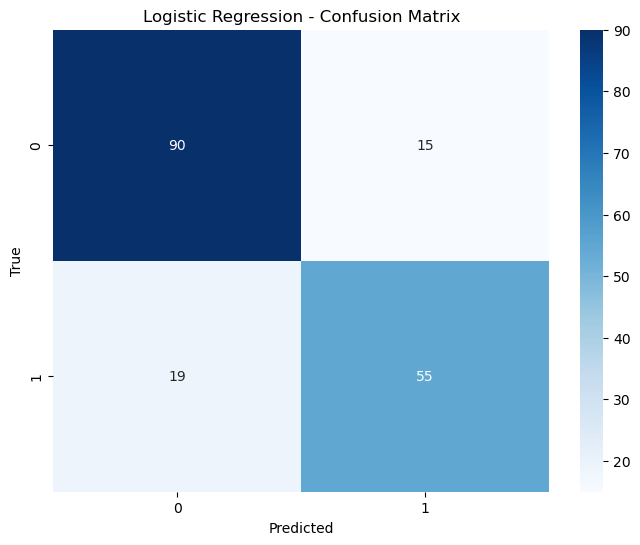

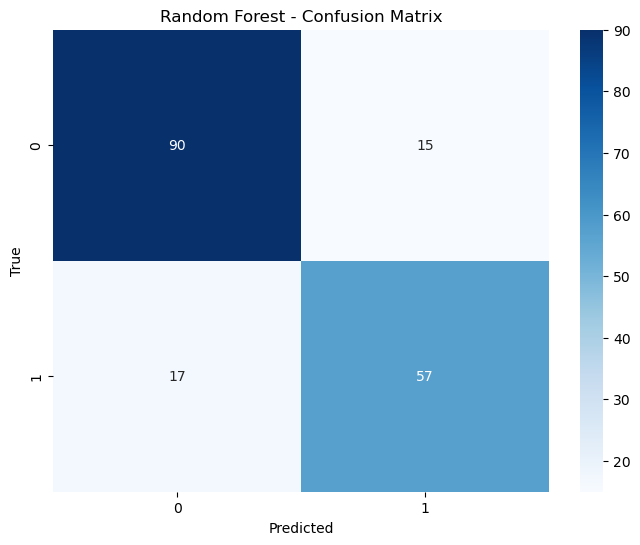

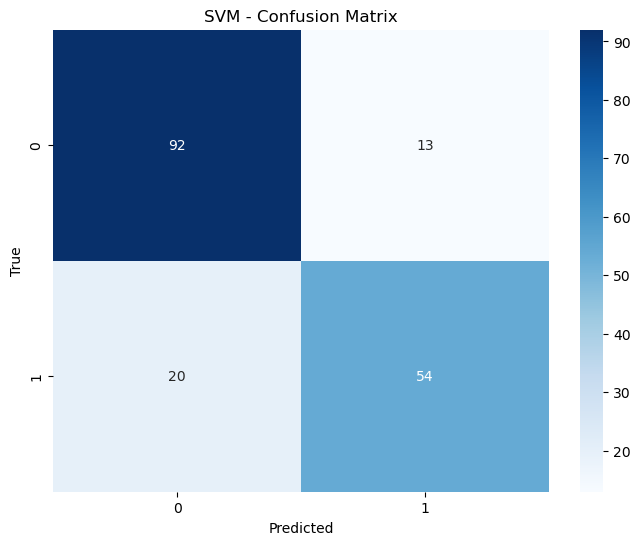

In [22]:
# 혼동 행렬 시각화
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()